In [1]:
from fastai import *
from fastai.text import *
import os

# Pre Processing

In [ ]:
! unzip fb.zip -d data/

In [2]:
path = 'data/messages/inbox'
me = 'Zachary Neveu'
senders = ['Andreas Hadjichristofi', 'Yousef Almesad']

Get the list of all messages you have sent and store it in a dataframe.  Write to CSV for later usage.

In [25]:
def get_sent(senders):
    df = pd.DataFrame(columns=['sender', 'content'])
    for subdir, dirs, files in os.walk(path):
        for file in files:
            if file.endswith('.json'):
                try:
                    convo = json.load(open(os.path.join(subdir, file)))
                    for m in convo['messages']:
                        if m['sender_name'] in senders:
                            df = df.append({'sender': m["sender_name"], 'content': m["content"]}, ignore_index=True)
                except Exception as e:
                    print(e)
    df.head()
    df.to_csv('data/sent.csv', index=False)

In [26]:
get_sent(senders)

'content'
'content'
'sender_name'


# Start Learning!

Start by creating a databunch using the [Data Block](https://docs.fast.ai/data_block.html) API

In [27]:
data = (TextList.from_csv(path=Path('data'), csv_name='sent.csv', cols='content')
        .random_split_by_pct()
        .label_for_lm()
        .databunch(bs=16)
        )

In [28]:
data.show_batch(rows=3)

idx,text
0,xxbos xxmaj yousef sent a photo from xxmaj tenor xxup gif xxmaj keyboard . xxbos xxmaj it was nt too xxunk vut just xxunk xxbos xxmaj play in the xxunk i mean xxbos i 'm down for whatever xxbos xxmaj there s also that xxunk place down ur xxunk that s good xxbos xxmaj but come on over whenever \n xxmaj and bring a xxunk pls \n i forgot mine
1,so what r ur thots on us heading out for running at 4 45ish \n xxmaj too early or nah ? xxbos xxmaj let 's say meet there 2 xxbos xxmaj go for xxunk xxbos i 'm pretty tired lmao xxbos does anyone want to go to the xxunk rush boston xxunk tonight xxbos xxmaj when u xxunk me xxbos i 'm down to ha g out or xxunk if
2,xxmaj do we need to rent a car / what 's the time table xxbos 8 o clock lobby . xxmaj yes ? xxbos i 'm down xxbos xxmaj hahahahaha whatever time ull be xxunk xxunk xxbos xxmaj near west xxunk xxbos xxmaj nice \n xxmaj we can go after u get xxunk in if u want xxbos xxmaj how do i get the eggplant xxbos xxunk is xxunk xxunk


In [29]:
data.save('lm_data')

Create a learner from a pre-trained language model

In [30]:
learn = language_model_learner(data, drop_mult=0.5, pretrained_model=URLs.WT103)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


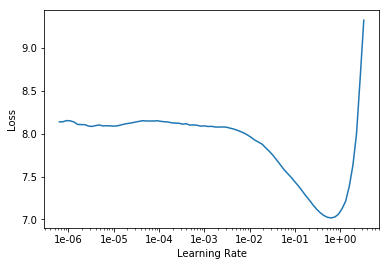

In [31]:
learn.lr_find()
learn.recorder.plot()

In [32]:
learn.fit_one_cycle(5, 3e-2)

epoch,train_loss,valid_loss,accuracy
1,6.186698,4.297101,0.220341
2,4.663898,3.708884,0.325335
3,4.066128,3.574620,0.338508
4,3.758836,3.509653,0.346251
5,3.581863,3.507186,0.345231


In [33]:
learn.save('stage_1')

In [34]:
learn.unfreeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


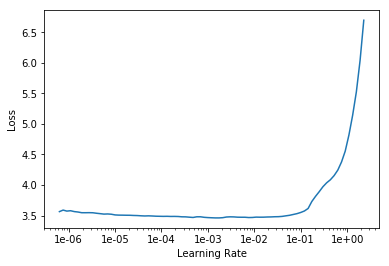

In [35]:
learn.lr_find()
learn.recorder.plot()

In [36]:
learn.fit_one_cycle(5, slice(1e-4, 2e-3))

epoch,train_loss,valid_loss,accuracy
1,3.479140,3.480321,0.346645
2,3.411836,3.447522,0.351043
3,3.338260,3.415867,0.355625
4,3.283949,3.404791,0.357350
5,3.255043,3.414781,0.355162


In [39]:
learn.save('stage_2')

In [38]:
learn.save_encoder('stage2_enc')

In [40]:
import re

In [41]:
text = learn.predict('What kind of food', n_words=25, min_p=0.001, no_unk=True)
re.sub(r'(xx...)', '', text)

'What kind of food ? ?  i got ta gym for friday in boylston rn yet so if you finish the trip up to 7:30 rn  '

# Classifier

In [4]:
data = TextClasDataBunch.from_csv(path='data', csv_name='sent.csv', classes=senders, label_cols=['sender'], text_cols=['content'], bs=16)

In [5]:
data.show_batch(rows=3)

text,target
xxbos xxfld 1 xxmaj start game with random xxunk : @fbchess play \n xxmaj pick the xxunk : @fbchess play white / black \n xxmaj pick the xxunk : @fbchess play white xxmaj john \n xxmaj make a move : use xxmaj standard xxmaj xxunk xxmaj xxunk \n @fbchess xxunk or @fbchess xxmaj xxunk xxunk xxunk to xxunk \n xxmaj xxunk to move xxunk from b,Yousef Almesad
xxbos xxfld 1 http : / / xxunk / us / xxmaj xxunk / xxmaj xxunk / xxmaj xxunk - xxmaj xxunk / xxup xxunk - xxmaj xxunk - xxunk - xxmaj xxunk / p / xxup xxunk \n if you 're in the market for a new xxunk . this one looks xxunk,Yousef Almesad
xxbos xxfld 1 xxmaj xxunk \n xxmaj dnt be late \n i checked online and made a xxunk \n xxmaj today it closes xxunk \n xxmaj its xxunk except xxunk and xxmaj xxunk . xxmaj that it 's open till 1 am,Yousef Almesad


In [6]:
learn = text_classifier_learner(data, drop_mult=0.5)

In [7]:
learn.load_encoder('stage2_enc')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


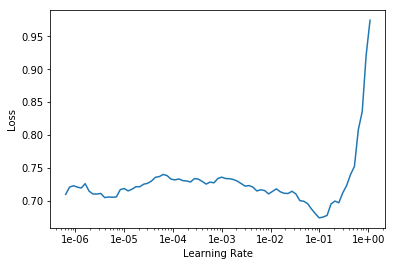

In [8]:
learn.lr_find()
learn.recorder.plot()

In [9]:
learn.fit_one_cycle(1, 2e-2, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy
1,0.543473,0.517520,0.761879


In [10]:
learn.save('first_clas')

In [ ]:
learn.load('first_clas')

In [11]:
learn.freeze_to(-2)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.476308,0.442997,0.807755


In [12]:
learn.save('second_clas')

In [13]:
learn.freeze_to(-3)
learn.fit_one_cycle(1, slice(5e-3/(2.6**4),5e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.432310,0.383701,0.835063


In [15]:
learn.save('third_clas')

In [17]:
learn.unfreeze()
learn.fit_one_cycle(2, slice(1e-3/(2.6**4),1e-3), moms=(0.8,0.7))

epoch,train_loss,valid_loss,accuracy
1,0.430757,0.367972,0.830694
2,0.401965,0.357294,0.842163


In [18]:
learn.save('final_clas')

In [19]:
learn.predict("Yo Fyi, me and shaheen r still planning in going to dinner.")

(Category Yousef Almesad, tensor(1), tensor([0.0404, 0.9596]))

In [29]:
learn.predict("I live on Westland")

(Category Yousef Almesad, tensor(1), tensor([0.3181, 0.6819]))

In [36]:
learn.predict("guys I really lik")

(Category Yousef Almesad, tensor(1), tensor([0.2590, 0.7410]))